In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from aux_funct import ewma_volatility, HoLee, plot_ho_lee_lattice

In [2]:
# Parameters

N = 2*12 # horizonte temporal en cantidad de meses
dt = 1/12 # paso temporal en años
r0 = 0.04761 # tasa inicial


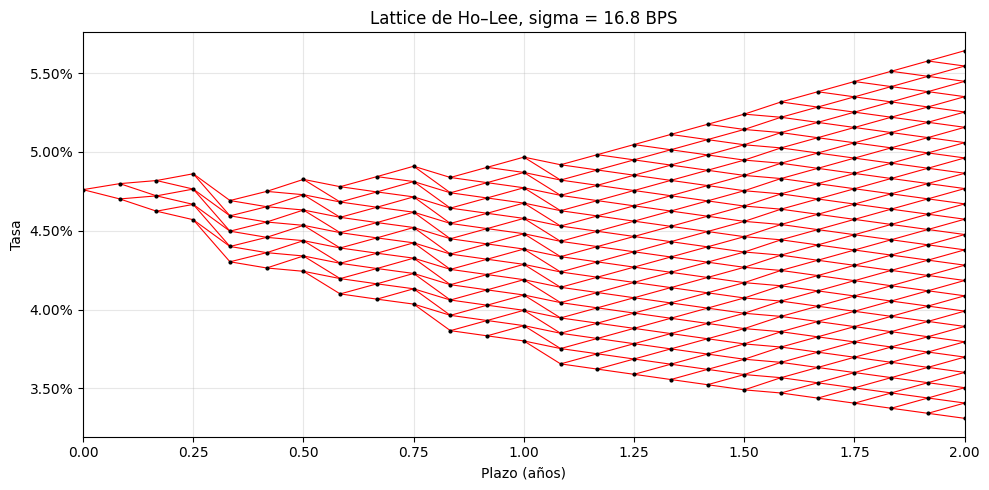

In [5]:
sigma = ewma_volatility('r1m.txt')
sigma = sigma[-1] # usando volatilidad spot

r = HoLee(sigma = sigma, N = N, dt = dt, r0 = r0, df_filename='df.txt')

plot_ho_lee_lattice(r = r, sigma = sigma)


